In [1]:
import sys
sys.path.append('../python_packages_static/')
import pandas as pd
import pyemu
import matplotlib.pyplot as plt
import numpy as np
import os, glob, shutil
import geopandas as gp
import datetime as dt
import flopy as fp
from shapely.geometry import Point
from matplotlib.backends.backend_pdf import PdfPages

# Postprocessing of iES runs. There are two key decisions to make. Which iteration is the best (subjective) tradeoff between fit and variance in the ensemble and, given a chosen iteration, what is an appropriate cutoff for rejection sampling. These decisions lead to visualization of the observation fits and generation of the ensemble to be used with MODPATH for the source water area delineation.

In [2]:
run_ensemble=False

In [3]:
if run_ensemble==True:
    rundir = '../run_data'                # directory in which runs took place
else:
    rundir = '../output/parallel'
pstroot = 'never_ies_0.noise_lt_obs'  # PST file root for iES
outfolder = '{}/postproc/'.format(rundir)  # write out output files to this location
obs_data = '../processed_data/'
drop_pdc = False

### Visualize the Phi of the whole ensemble as it evolves over the iterations

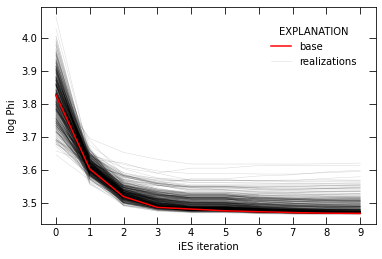

In [23]:
phi = pd.read_csv(os.path.join(rundir,"{}.phi.actual.csv".format(pstroot)),index_col=0)
plt.figure(figsize=(6,4))
ax = phi['base'].apply(np.log10).plot(legend=False, lw=1.5, color='r', label='base')
phi.iloc[:,6:7].apply(np.log10).plot(legend=False,lw=0.5,color='k',alpha=0.15,label='realizations', ax = ax)
plt.legend(['base','realizations'])
phi.iloc[:,6:].apply(np.log10).plot(legend=False,lw=0.5,alpha=0.15,color='k', ax = ax)
phi['base'].apply(np.log10).plot(legend=False, lw=1.5, color='r', ax=ax)
plt.ylabel('log Phi')
plt.xlabel('iES iteration')
plt.xticks(ticks=np.arange(10))
ax.axes.tick_params(length=7, direction='in', right=True, top=True)
plt.legend(['base','realizations'], title='EXPLANATION', frameon=False, bbox_to_anchor =(0.97, 0.95))


In [5]:
phi

,total_runs,mean,standard_deviation,min,max,0,1,2,3,4,...,490,491,492,493,494,495,496,497,498,base
iteration,,,,,,,,,,,,,,,,,,,,,
0,500,6795.30,1140.490,4426.38,11589.20,6932.28,8591.66,9484.93,6204.96,5153.65,...,8214.17,8199.26,5381.08,6395.55,6098.38,8375.92,9096.47,5798.44,7211.02,6710.94
1,1143,4100.26,210.244,3592.58,4957.09,3910.25,4259.87,4301.77,4075.78,4413.70,...,4495.08,3607.22,3894.55,3791.85,3888.53,3908.82,4213.20,4151.77,3873.70,4008.38
2,1780,3399.48,176.986,3094.35,4498.10,3153.76,3588.78,3194.49,3324.72,3648.75,...,3901.50,3240.58,3271.71,3316.42,3334.90,3264.30,3294.27,3471.25,3178.23,3304.48
3,2410,3206.45,173.336,2983.44,4284.15,3031.73,3429.89,3140.27,3186.34,3428.76,...,3685.40,3070.19,3169.03,NaN,3069.70,3059.40,3056.28,3264.86,3071.24,3064.73
4,3033,3131.77,166.123,2949.33,4146.75,2971.02,3345.52,3163.38,3152.54,3283.10,...,3558.23,3018.40,3095.30,NaN,2999.00,3012.51,3000.66,3176.84,3008.23,3028.94
5,3193,3130.80,165.983,2949.33,4146.75,2971.02,3345.52,3163.38,3152.54,3283.10,...,3558.23,3018.40,3095.30,NaN,2999.00,3012.51,3000.66,3176.84,3008.23,2992.65
6,3815,3091.13,167.317,2928.34,4149.59,2947.47,3267.32,3153.28,3136.60,3225.26,...,3507.80,2992.70,3044.94,NaN,2998.25,2993.07,2983.30,3118.61,2988.16,2974.26
7,4420,3070.07,169.696,2923.22,4144.80,2941.24,3232.03,3161.05,3134.12,3205.97,...,NaN,NaN,3033.30,NaN,NaN,NaN,NaN,NaN,NaN,2956.28
8,5025,3058.01,175.449,2920.96,4155.12,2937.96,3214.41,3133.98,3120.76,3201.46,...,NaN,NaN,3016.92,NaN,NaN,NaN,NaN,NaN,NaN,2943.16


In [6]:
pst = pyemu.Pst('{0}/{1}.pst'.format(rundir, pstroot))

### a `bounds_report` helps visualize, for the base realization, how many parameters were at their bounds. This can help guide the decision of whether iterations are overfit or not.

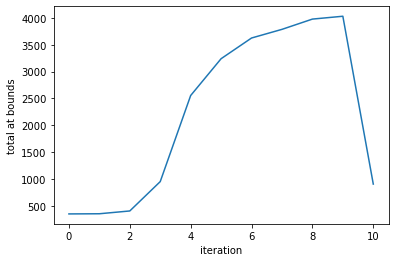

In [7]:
df = pst.bounds_report()
df_tot =  df[[i for i in df.columns if 'either' in i]].loc['total'].copy()
df_tot.index = [int(i.split('_')[-1]) for i in df_tot.index]
df_tot.plot()
plt.xlabel('iteration')
plt.ylabel('total at bounds')
plt.grid()
plt.grid()

### we are choosing iteration 4 as best

In [8]:
best_iter = 4
# re-read in the PST file but now with the residuals corresponding with the best iteration
pst = pyemu.Pst('{0}/{1}.pst'.format(rundir, pstroot), 
                resfile=os.path.join(rundir,'{}.{}.base.rei'.format(pstroot,best_iter)))
obs=pst.observation_data

### we can make a quick 1to1 plot of the base ensemble member

In [9]:
pst.plot(kind='1to1', filename='../figures/{0}.{1}_iter_{2}.pdf'.format( pstroot, '.base.1to1', best_iter))


### here we decide whether or not we will visualize results which were in prior data conflict (PDC)

In [10]:
if drop_pdc is True:
    # read in the PDC list of values
    pdc = pd.read_csv(os.path.join(rundir,'{}.pdc.csv'.format(pstroot)))
    pdc.name = pdc.name.apply(lambda x: x.lower())
    # zero weight all the PDC values
    obs.loc[pdc.name.values, 'weight'] = 0

## plot residuals only for nonzero weight for the base realization which is read in automatically when `pyemu` reads in the pst control file

In [11]:
assert(np.unique(pst.res.index == obs.index))==np.array(True)

In [12]:
tmpres = pst.res.copy()
tmpres.weight = obs.weight


In [13]:
tmpres = tmpres.loc[pst.res.weight>0]
print(len(tmpres))
tmpres.head()

525


,name,group,measured,modelled,residual,weight
name,,,,,,
q_1436500,q_1436500,flux,116217.231560,101680.000000,14537.231560,0.001014
q_1366650,q_1366650,flux,124046.273310,128230.000000,-4183.726690,0.002852
h_414525074360601,h_414525074360601,head,357.182016,359.093466,-1.911451,0.091297
h_o10577,h_o10577,head,203.903379,195.797668,8.105710,0.091297
h_o10942,h_o10942,head,150.660417,155.416464,-4.756047,0.091297


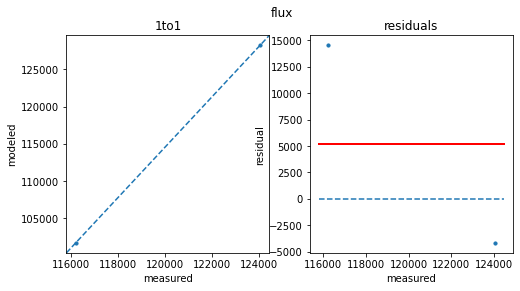

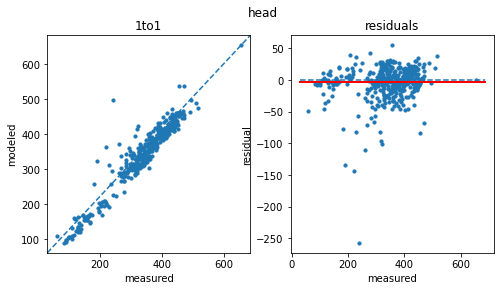

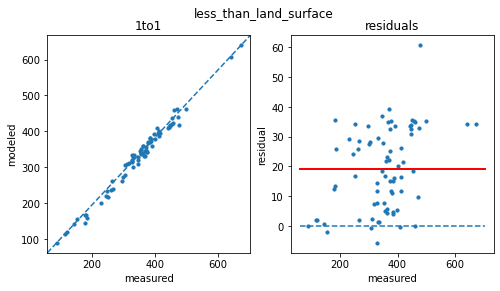

In [14]:
for cn,cg in tmpres.groupby('group'):
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].plot([0, 1], [0, 1],'--',transform=ax[0].transAxes)
    ax[0].scatter(cg.measured,cg.modelled, s=10)
    ax[0].set_xlabel('measured')
    ax[0].set_ylabel('modeled')
    ax[0].set_title('1to1')
    ax[1].scatter(cg.measured, cg.residual, s=10)
    xlim = ax[1].get_xlim()
    ax[1].plot(xlim, [0,0], '--')
    ax[1].plot(xlim, [cg.residual.mean(),cg.residual.mean()], 'r-', lw=2)
    ax[1].set_title('residuals')
    plt.suptitle(cn)
    ax[1].set_xlabel('measured')
    ax[1].set_ylabel('residual')

# Rejection Sampling. We can look at the PHI histogram for the best iteration and assign a cutoff of `phi_too_high` which delineates where rejection takes place

In [15]:
phivec = phi.loc[best_iter][5:].copy()

<AxesSubplot:>

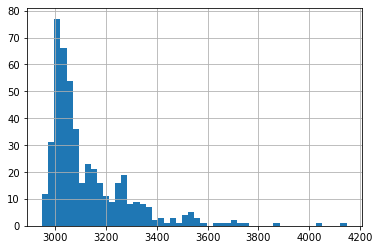

In [16]:
phivec.hist(bins=50)

In [17]:
phi_too_high= 3200 

## the next couple cells seem extra involved, but they are meant to make fancy figures for the journal; article showing PHI evolution over iterations and the rejection sampling all together.

In [18]:
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

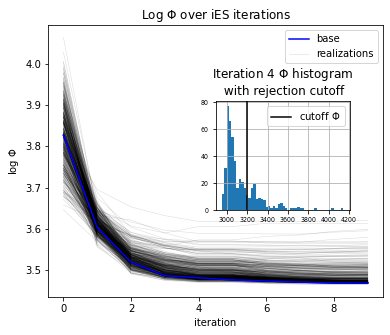

In [25]:
fig = plt.figure(figsize=(6,5))
ax = phi['base'].apply(np.log10).plot(legend=False, lw=1.5, color='b', label='base')
phi.iloc[:,6:7].apply(np.log10).plot(legend=False,lw=0.5,color='k',alpha=0.15,label='realizations', ax = ax)
plt.legend(['base','realizations'])
phi.iloc[:,6:].apply(np.log10).plot(legend=False,lw=0.5,alpha=0.15,color='k', ax = ax)
phi['base'].apply(np.log10).plot(legend=False, lw=1.5, color='b', ax=ax)
plt.ylabel('log $\Phi$')

ax1 = add_subplot_axes(ax, [0.5,.32,.4,0.4])
ax1.axvline(phi_too_high, color='k', label='cutoff $\Phi$')
ax1.legend()
phivec = phi.loc[best_iter][5:].copy()
phivec.hist(bins=50, ax=ax1)
ax.set_title('Log $\Phi$ over iES iterations')
ax1.set_title('Iteration 4 $\Phi$ histogram\n with rejection cutoff') 

plt.savefig('../figures/phi_and_rejection.pdf')

Number of reals before rejection sampling: 500
Number of reals after rejection sampling: 358


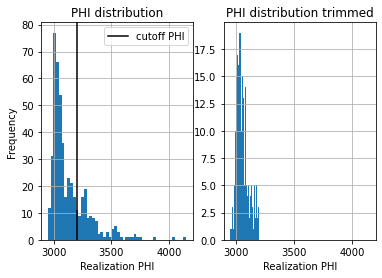

In [30]:
phivec = phi.loc[best_iter][5:].copy()
fig, ax = plt.subplots(1,2, figsize=(6,4))
phivec.hist(bins=50, ax=ax[0])
ax[0].axvline(phi_too_high, color='k', label='cutoff PHI')
ax[0].legend()
ax[0].set_ylabel('Frequency')
print('Number of reals before rejection sampling: {}'.format(len(phivec)))
phivec = phivec[phivec<phi_too_high]
print('Number of reals after rejection sampling: {}'.format(len(phivec)))
phivec.hist(bins=50, ax=ax[1])
ax[1].set_xlim(ax[0].get_xlim())
ax[0].set_xlabel('Realization PHI')
ax[1].set_xlabel('Realization PHI')
ax[0].set_title('PHI distribution')
ax[1].set_title('PHI distribution trimmed')

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, loc='best')


plt.savefig('../figures/Figure20_rejectionsampling.pdf')

### now we need to make a `reals_to_keep` vector that keeps track of the ensemble members that made it through rejection sampling

In [31]:
reals_to_keep = phivec.index.values

### in early stages of the project, there were cases where some model results with reasonable PHI had poor mass balance, so we rejected them as well. Now that is not a problem, but the logic is shown here nonetheless.

In [32]:
# truncate the ensemble to only reals_to_keep (based on phi)
ens = pd.read_csv(os.path.join(rundir,'{}.0.obs.csv'.format(pstroot)), index_col=0)

ens = ens.loc[reals_to_keep]
# set percent_discrepancy to absolute value because we don't care about the sign
ens.perc_disc = ens.perc_disc.apply(lambda x: np.abs(x))

In [35]:
# further truncate to eliminate bad mass balance runs 
ens = ens.loc[ens.perc_disc<0.01]
ens

,q_1436500,q_1366650,h_414525074360601,h_o10577,h_o10942,h_o11068,h_o5124,h_o6269,h_o7421,h_o8073,...,land_surf_obs_500_400,land_surf_obs_500_450,land_surf_obs_500_500,land_surf_obs_550_400,land_surf_obs_550_450,land_surf_obs_550_500,land_surf_obs_600_350,land_surf_obs_600_400,land_surf_obs_600_450,land_surf_obs_650_450
real_name,,,,,,,,,,,,,,,,,,,,,
0,95226,145490,358.418,201.242,155.240,111.311,341.365,480.390,148.231,200.436,...,400.988,216.586,167.168,323.550,166.667,330.867,411.284,273.919,154.860,241.344
2,99750,152280,359.100,200.740,155.372,113.440,340.930,477.603,147.165,199.901,...,398.971,216.578,167.499,322.784,166.855,330.831,410.060,273.211,155.129,240.580
3,96978,143760,359.337,192.648,155.380,110.553,338.615,473.096,142.882,198.017,...,392.311,216.469,165.550,317.337,165.981,330.221,408.224,272.665,154.702,237.611
5,99275,142330,359.353,186.681,156.222,112.129,337.452,471.582,141.081,197.511,...,389.110,216.450,165.018,316.973,166.673,330.106,407.479,272.530,155.205,236.147
6,96987,145610,358.872,197.691,155.109,113.372,340.094,474.676,144.894,198.801,...,395.009,216.504,165.428,320.125,166.604,330.417,408.972,272.830,155.001,238.783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,99408,149830,359.061,198.004,155.049,110.622,339.903,475.998,145.150,198.883,...,395.904,216.504,166.770,320.876,167.171,330.418,409.571,272.976,155.321,238.850
496,98395,151420,359.007,196.895,155.669,111.953,340.194,474.981,145.105,198.835,...,394.988,216.518,166.276,320.977,164.654,330.399,409.109,272.727,155.374,238.112
497,97512,142470,359.103,199.085,155.799,114.105,340.798,477.101,146.006,199.225,...,397.101,216.518,167.316,321.121,168.643,330.643,410.304,273.340,154.814,240.259


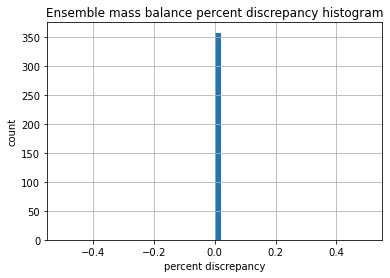

In [39]:
ens.perc_disc.hist(bins=50)
plt.title('Ensemble mass balance percent discrepancy histogram')
plt.ylabel('count')
plt.xlabel('percent discrepancy')
plt.show()

In [40]:
# get rid of zero-weighted values dropped in the PDC
ens = ens[tmpres.index]

In [41]:
# reset keepreals based now both on phi and mass balance
reals_to_keep = ens.index.values

In [42]:
phivec = phivec.loc[reals_to_keep]

<AxesSubplot:>

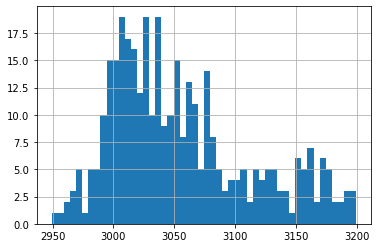

In [43]:
phivec.hist(bins=50)

In [ ]:
base_ens = pd.read_csv(os.path.join(rundir,'{}.0.obs.csv'.format(pstroot)), index_col=0)
base_ens = base_ens.loc[reals_to_keep]
base_ens = base_ens[tmpres.index]
pyemu.plot_utils.ensemble_res_1to1(ens, pst, base_ensemble=base_ens)

In [ ]:
pdc = pd.read_csv(os.path.join(rundir,'{}.pdc.csv'.format(pstroot)))
pdc.name = pdc.name.apply(lambda x: x.lower())
pdc.set_index('name', inplace=True, drop=True)
pdc

## plot without PDC 

In [ ]:
drop_pdc = [i for i in pdc.index if not i.startswith('q_')] # make sure we still plot streamflow even if in PDC. 
        # should not be the case

In [ ]:
ens = ens[[i for i in ens.columns if i not in drop_pdc]]
base_ens = base_ens[[i for i in ens.columns if i not in drop_pdc]]

In [ ]:
tmpres = tmpres.loc[[i for i in ens.columns if i not in drop_pdc]]

In [ ]:
obs_ens = pd.read_csv(os.path.join(rundir,'{}.obs+noise.csv'.format(pstroot)), index_col=0)
obs_ens = obs_ens.loc[reals_to_keep]
obs_ens


## In this case, with sampling of observation noise, looking for overlap of distributions

In [ ]:
plot_pdf = False

In [ ]:
if plot_pdf==True:
    with PdfPages('../figures/{}_trimmed_pdc_obs_hist_plots.pdf'.format(pstroot))) as outpdf:
        for cob in tmpres.index.values:
            plt.figure()

            obs_ens[cob].hist(bins=50, color='orange', edgecolor='none', alpha=.7,label='observed')
            ens[cob].hist(bins=50, edgecolor='none', label='modelled')
            plt.axvline(obs_ens[cob].mean(), mfc='k', alpha=.5,label='obs mean')
            plt.axvline(obs_ens[cob].mean()+obs_ens[cob].std(), mfc='k', ls=':', alpha=.5, label='obs + 1$\sigma$')
            plt.axvline(obs_ens[cob].mean()-obs_ens[cob].std(), mfc='k', ls=':', alpha=.5, label='obs - 1$\sigma$')


            plt.title(cob)
            plt.legend()
            outpdf.savefig()
            plt.close('all')


# Finally, after all the visualization, we save out the paremeter ensemble to supply to MODPATH for the final source water area delineation

In [ ]:
par_ens = pd.read_csv(os.path.join(rundir,'{0}.{1}.par.csv'.format(pstroot, best_iter)), index_col=0)
par_ens.index = [str(i) for i in par_ens.index]
par_ens = par_ens.loc[reals_to_keep]
par_ens.to_csv('../run_data/modpath_par_ens.csv')